Team : Ruila PUSKAS-JUHASZ and Agathe LHOPITEAU

# Challenge SD-TSIA210

In [2]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

Using TensorFlow backend.


### Load and investigate the Data

In [3]:
Xtrain = np.loadtxt('xtrain_challenge.csv', delimiter=',', skiprows = 1)
Ytrain = np.loadtxt('ytrain_challenge.csv', delimiter=',', skiprows = 1)
Xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)

#Let's check the shape of the training sets
print(Xtrain.shape)
print(Ytrain.shape)

#Using our own training data to test
#X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Ytrain, test_size = 0.20)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

(1068504, 37)
(1068504,)


Before processing and testing the data, we are goint to visualize it to see if it is linearly separable. 

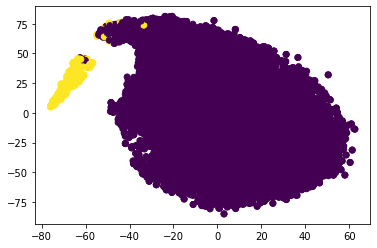

In [4]:
#Let's visualize the first 10.000 inputs of our dataset
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(Xtrain[:10000])

X,Y=[],[]
for i in range(len(X_embedded)) :
    X.append(X_embedded[i][0])
    Y.append(X_embedded[i][1])

plt.scatter(X, Y, c=Ytrain[:10000])
plt.show()

The distribution of the data is heterogenous, so we can separate it in two classes. 
<br> 
After this remark, we are going to scale the data to gain efficiency during the learning processes. 

In [5]:
#Scaling the data for more efficiency during learning processes
Xtrain = preprocessing.scale(Xtrain)
Xtest = preprocessing.scale(Xtest)

## Let's try a few methods


## Deep Neural Network

In [26]:
from keras.layers import Dropout

data = Xtrain
labels = Ytrain
modelDNN = Sequential()
modelDNN.add(Dense(32,activation='softmax',input_dim=37))
#modelDNN.add(Dropout(0.5))
modelDNN.add(Dense(1, activation='sigmoid'))

#modelDNN.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])

from keras.optimizers import SGD
opt = SGD(lr=0.01)
modelDNN.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

modelDNN.fit(data,labels,epochs=10,batch_size=32)
Ypred_dnn = modelDNN.predict(Xtest)
 

Epoch 1/10
1068504/1068504 [==============================] - 18s 17us/step - loss: 0.0679 - accuracy: 0.9816
Epoch 2/10
1068504/1068504 [==============================] - 18s 17us/step - loss: 0.0186 - accuracy: 0.9976
Epoch 3/10
1068504/1068504 [==============================] - 18s 17us/step - loss: 0.0126 - accuracy: 0.9978
Epoch 4/10
1068504/1068504 [==============================] - 17s 16us/step - loss: 0.0103 - accuracy: 0.9980
Epoch 5/10
1068504/1068504 [==============================] - 19s 17us/step - loss: 0.0092 - accuracy: 0.9980
Epoch 6/10
1068504/1068504 [==============================] - 18s 17us/step - loss: 0.0085 - accuracy: 0.9980
Epoch 7/10
1068504/1068504 [==============================] - 18s 17us/step - loss: 0.0081 - accuracy: 0.9980
Epoch 8/10
1068504/1068504 [==============================] - 18s 17us/step - loss: 0.0077 - accuracy: 0.9980
Epoch 9/10
1068504/1068504 [==============================] - 18s 17us/step - loss: 0.0075 - accuracy: 0.9981
Epoch 10/1

For 10000 features, we get good accuracies: 0.9627 0.9857 0.9592 0.9589 0.9589 0.9589 0.9859 0.9969 0.9973 0.9973 <br>
For the whole dataset, the accuracy increases but not drastically: 0.9955 0.9976 0.9975 0.9976 0.9976 0.9977 0.9978 0.9978 0.997 0.9978 <br>
These accuracies are not as good as good as a random forest alone. Hence, we will have to combine different algorithms to have a higher accuracy.  

## Random Forest

Before training the random forest algorithm, we are going to tune the parameters, that is,  the number of trees needed for the forest to correctly predict Xtest. To do that, we'll use a Grid Search. <br>
We test three values 50, 100 and 200 because our manual tries showed that the number of tree is between 50 and 200, and that 100 is a presumably good number. Let's verify that this assumption is correct. 

In [6]:
from sklearn.ensemble import RandomForestClassifier



############################# First we apply a grid search to see which parameter is the best######
rfclass = RandomForestClassifier()

#Create a dictionnary of all values we want to test for n_estimators, aka the number of trees
params_rf = {"n_estimators": [50, 100, 200]}

#use gridsearch to test all values for n_estimators
modelRF_gs = GridSearchCV(rfclass, params_rf, cv=5)

# Fit on training data
modelRF_gs.fit(Xtrain[:100000], Ytrain[:100000])

#save best model
rf_best = modelRF_gs.best_estimator_

#check best n_estimators value
print(modelRF_gs.best_params_)

{'n_estimators': 100}


When we compute the grid search, we get : 
* for 1000 features : 100 trees
* for 10 000 features : 50 trees
* for 100 000 features : 100 trees
* for the whole data set : 100 trees. 

<br> We will thus chose 100 trees for our random forest. 

In [6]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Ytrain, test_size = 0.20)

from sklearn.ensemble import RandomForestClassifier
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
Ypred_forest = model.predict(Xtest)

In [ ]:
#Let's create our file that will be compared to Ytest
np.savetxt('ytest_challenge_LHOPITEAU.csv', Ypred_forest, fmt = '%1.0d', delimiter=',')

Using only this random forest, we have a pretty good result : accuracy of 0.998063463898. Moreover, the computing time isn't very long, so this method is pretty efficient and we decide to keep it for our ensemble learning.

## Logistic regression 

We don't need to do any fine-tuning Grid Search for the Logistic Regression classifier. Furthermore, the computing time is quite short so we decide to keep this method as well in our ensemble. 

In [8]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xtrain, Ytrain)

/Users/ruilapuskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
Ypred_logreg = logreg.predict(Xtest)

In [17]:
#Let's create our file that will be compared to Ytest
np.savetxt('ytest_challenge_LHOPITEAU.csv', Ypred_logreg, fmt = '%1.0d', delimiter=',')

This method provides a pretty good accuracy : 0.9978, and is computed very quickly (less than 5 minutes). We thus decide to keep it for our futur ensemble learning.

## K-nearest neighbours

In [10]:
############WITHOUT ENSEMBLES###################
#We fix the number of neighbors equal to 100
#clfKNN = KNeighborsClassifier(n_neighbors=100)
#clfKNN = clfKNN.fit(Xtrain, Ytrain)

#We predict the labels 
#Ypred_knn = clfKNN.predict(Xtest)

#Compute the accuracy
#accuracy_score(Ypred_knn, Y_test)


###########WITH ENSEMBLES########################
#create new a knn model
knn = KNeighborsClassifier()

#We want to test 30 different values for each neighbor
params_knn = {'n_neighbors': np.arange(1, 9)}

#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=3)

#fit model to training data
knn_gs.fit(Xtrain[:10000], Ytrain[:10000])

#save best model
knn_best = knn_gs.best_estimator_

#check best n_neigbors value
print(knn_gs.best_params_)

#Prepare for submission
#np.savetxt('ytest_knn.csv', Ypred_knn, fmt = '%1.0d', delimiter = ',')

#Prepare for submission
ytest_knn = knn_best.predict(Xtest)
#np.savetxt('ytest_knn.csv', ytest_knn, fmt = '%1.0d', delimiter = ',')

{'n_neighbors': 3}


Knn is very quick for features under 100 000, after it is rather slow. To get free from this long computation of the grid search and of the fit, we will test manually the results given by this code for 1000, 10000, 100 000 features. We see that there is a tendancy: the number of neighbours seems to tend towards 3, so we will keep this parameter in the following cell. 

In [ ]:
####### DO NOT RUN #################
modelKNN = KNeighborsClassifier(3)
modelKNN.fit(Xtrain, Ytrain)
Ypred_knn = modelKNN.predict(Xtest)

When we use our own dataset (with a train_test_split), with the K-nearest neighbours method, we get a computation time of approximately 5 minutes and we get an accuracy of 0.9975245787338384, when we take 3 neighbors. 
<br> However, after running the above cell on the whole dataset, the program is still running after 16 hours! After trying different possibilities (Google Colab, connecting to a school computer) that didn't work because of connectivity problems mainly, we decided to drop this method and focus on the Deep Neural Network, the Random Forest and Logistic Regression and see how we can combine them.

## Now let's vote for best classifier

In [24]:
Ypred = []
for i in range(len(Ypred_logreg)):
    if Ypred_logreg[i] + Ypred_forest[i] + Ypred_gb[i] >= 2 :
        Ypred.append(1)
    else :
        Ypred.append(0)
Ypred = np.array(Ypred)

np.savetxt('ytest_challenge_LHOPITEAU_PUSKAS.csv', Ypred, fmt = '%1.0d', delimiter = ',')

For 1000 features, we get a final accuracy of 0.9955 which is lower than when we use only the random forrest. 
When we increase the number of features however, this accuracy increases as well: 0.9976696412276966 for 10000 features

## Gradient Boosting

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

#scaling the data
#scaler = MinMaxScaler()
#Xtrain = scaler.fit_transform(Xtrain)
#Xtest = scaler.transform(Xtest)

#learning rate list
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=learning_rate, max_features=2, max_depth=5, random_state=0)
    gb_clf.fit(Xtrain, Ytrain)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(Xtrain, Ytrain)))
    #print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.997
Learning rate:  0.075
Accuracy score (training): 0.998
Learning rate:  0.1
Accuracy score (training): 0.998
Learning rate:  0.25
Accuracy score (training): 0.999
Learning rate:  0.5
Accuracy score (training): 0.998
Learning rate:  0.75
Accuracy score (training): 0.998
Learning rate:  1
Accuracy score (training): 0.997


In [23]:
gb_clf2 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_features=2, max_depth=5, random_state=0)
gb_clf2.fit(Xtrain, Ytrain)
Ypred_gb = gb_clf2.predict(Xtest)

#print("Confusion Matrix:")
# print(confusion_matrix(y_val, predictions))

In [25]:
Ypred_gb

array([0., 0., 0., ..., 0., 0., 0.])